In [86]:
import matplotlib.pyplot as plt

In [87]:
import numpy as np

In [88]:
class Value:
    def __init__(self, data, _children=(), _op=''):
        self.data = data
        self._op = _op
        self._prev = set(_children)
    def __repr__(self):
        return f"Value(data={self.data})"
    def __add__(self, other):
        return Value(self.data + other.data, (self,other), '+')
    def __mul__(self, other):
        return Value(self.data * other.data, (self,other), '*')

In [89]:
a = Value(2.0)
b = Value(-3.0)
c = Value(10.0)

In [90]:
a*b

Value(data=-6.0)

In [91]:
d = a*b+c

In [92]:
d._prev

{Value(data=-6.0), Value(data=10.0)}

In [93]:
d._op

'+'

In [98]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{data %.4f}" % (n.data), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

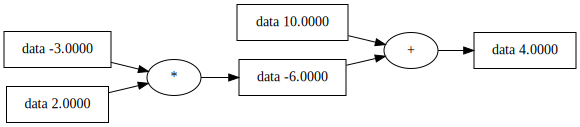

In [99]:
draw_dot(d)